<a href="https://colab.research.google.com/github/pravin-raut/TimeSeries_USD-EUR_WithOilImpact/blob/Master/MLP_Preciction_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Quandl- Get Grude Oil Prices from Nasdaq
# Install yfinance- Get Grude USD-EUR Exchange Rate from yFinance

In [ ]:
!pip install quandl
!pip install yfinance
!pip install --upgrade ipykernel


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

# Secret API key to fetch data from Nasdaq

In [ ]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


In [ ]:
LastDay='2023-07-10'
FirstDay='2019-01-01'


In [ ]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

# Fetch Oil Data
1. Set Date as Index
2. Set Frequency of days as business
3. Fill the missing days which are holidays as their prior values

In [ ]:

df_Oil_InUSD=getDataFromAPI("Nasdaq","OPEC/ORB",FirstDay,LastDay).reset_index()
df_Oil_InUSD['Date'] = pd.to_datetime(df_Oil_InUSD['Date']).dt.date
df_Oil_InUSD.set_index('Date', inplace=True)
# Set Frequencey as B
df_Oil_InUSD=df_Oil_InUSD.asfreq('b')
df_Oil_InUSD['Actual_Oil_Price_t']=df_Oil_InUSD.Value.fillna(method='bfill')
df_Oil_InUSD=df_Oil_InUSD[['Actual_Oil_Price_t']]
df_Oil_InUSD.head(5)

,Actual_Oil_Price_t
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09


# Fetch USD-EUR Exchange data Data
1. Set Date as Index
2. Set Frequency of days as business
3. Fill the missing days which are holidays as their prior values

In [ ]:
df_USD_EUR=getDataFromAPI("YFinance","EURUSD=X",FirstDay,LastDay).reset_index()
df_USD_EUR['Date'] = pd.to_datetime(df_USD_EUR['Date']).dt.date
df_USD_EUR.set_index('Date', inplace=True)
df_USD_EUR=df_USD_EUR.asfreq('b')
df_USD_EUR.Close=df_USD_EUR.Close.fillna(method='bfill')
df_USD_EUR['Actual_USD_EUR_Price_t']=df_USD_EUR[['Close']]
df_USD_EUR=df_USD_EUR[['Actual_USD_EUR_Price_t']].iloc[1:]
df_USD_EUR.head(5)

,Actual_USD_EUR_Price_t
Date,
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
2019-01-08,1.147974


# Create shift of values of previous days which will be used as features

In [ ]:
def generate_shift_columns_back(df, column_name, min_shift, max_shift):
    for i in range(min_shift, max_shift + 1):
        df[f'{column_name}-{i}'] = df[column_name].shift(i)
    return df


# Create shift of values of future days which will be used for Comparison and t+1 will be used for prediction

In [ ]:
def generate_shift_columns_front(df, column_name, min_shift, max_shift):
    for i in range(min_shift, max_shift + 1):
        df[f'{column_name}+{i}'] = df[column_name].shift(-i)
    return df


#Joining both dataframe

In [ ]:
df_oil_currency = df_Oil_InUSD.join(df_USD_EUR, how='inner')


In [ ]:
df_oil_currency.index.isocalendar().week

Date
2019-01-02     1
2019-01-03     1
2019-01-04     1
2019-01-07     2
2019-01-08     2
              ..
2023-07-03    27
2023-07-04    27
2023-07-05    27
2023-07-06    27
2023-07-07    27
Freq: B, Name: week, Length: 1178, dtype: UInt32

In [ ]:
df_oil_currency['year'] = df_oil_currency.index.year
df_oil_currency['month'] = df_oil_currency.index.month
df_oil_currency['day'] = df_oil_currency.index.day
df_oil_currency['day_of_week'] = df_oil_currency.index.dayofweek
df_oil_currency['weeknum'] = df_oil_currency.index.isocalendar().week
df_oil_currency

,Actual_Oil_Price_t,Actual_USD_EUR_Price_t,year,month,day,day_of_week,weeknum
Date,,,,,,,
2019-01-02,52.14,1.146171,2019,1,2,2,1
2019-01-03,52.93,1.131811,2019,1,3,3,1
2019-01-04,55.13,1.139108,2019,1,4,4,1
2019-01-07,56.42,1.141044,2019,1,7,0,2
2019-01-08,56.09,1.147974,2019,1,8,1,2
...,...,...,...,...,...,...,...
2023-07-03,76.12,1.090750,2023,7,3,0,27
2023-07-04,76.18,1.091310,2023,7,4,1,27
2023-07-05,76.61,1.088495,2023,7,5,2,27


In [ ]:
generate_shift_columns_back(df_oil_currency, 'Actual_USD_EUR_Price_t', 1, 4)
generate_shift_columns_back(df_oil_currency, 'Actual_Oil_Price_t', 1, 4)
df_oil_currency.head(5)

,Actual_Oil_Price_t,Actual_USD_EUR_Price_t,year,month,day,day_of_week,weeknum,Actual_USD_EUR_Price_t-1,Actual_USD_EUR_Price_t-2,Actual_USD_EUR_Price_t-3,Actual_USD_EUR_Price_t-4,Actual_Oil_Price_t-1,Actual_Oil_Price_t-2,Actual_Oil_Price_t-3,Actual_Oil_Price_t-4
Date,,,,,,,,,,,,,,,
2019-01-02,52.14,1.146171,2019,1,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,52.93,1.131811,2019,1,3,3,1,1.146171,NaN,NaN,NaN,52.14,NaN,NaN,NaN
2019-01-04,55.13,1.139108,2019,1,4,4,1,1.131811,1.146171,NaN,NaN,52.93,52.14,NaN,NaN
2019-01-07,56.42,1.141044,2019,1,7,0,2,1.139108,1.131811,1.146171,NaN,55.13,52.93,52.14,NaN
2019-01-08,56.09,1.147974,2019,1,8,1,2,1.141044,1.139108,1.131811,1.146171,56.42,55.13,52.93,52.14


In [ ]:
generate_shift_columns_front(df_oil_currency, 'Actual_USD_EUR_Price_t', 1, 5)
generate_shift_columns_front(df_oil_currency, 'Actual_Oil_Price_t', 1, 5)
df_oil_currency.head(5)

,Actual_Oil_Price_t,Actual_USD_EUR_Price_t,year,month,day,day_of_week,weeknum,Actual_USD_EUR_Price_t-1,Actual_USD_EUR_Price_t-2,Actual_USD_EUR_Price_t-3,...,Actual_USD_EUR_Price_t+1,Actual_USD_EUR_Price_t+2,Actual_USD_EUR_Price_t+3,Actual_USD_EUR_Price_t+4,Actual_USD_EUR_Price_t+5,Actual_Oil_Price_t+1,Actual_Oil_Price_t+2,Actual_Oil_Price_t+3,Actual_Oil_Price_t+4,Actual_Oil_Price_t+5
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,52.14,1.146171,2019,1,2,2,1,NaN,NaN,NaN,...,1.131811,1.139108,1.141044,1.147974,1.145607,52.93,55.13,56.42,56.09,58.22
2019-01-03,52.93,1.131811,2019,1,3,3,1,1.146171,NaN,NaN,...,1.139108,1.141044,1.147974,1.145607,1.155495,55.13,56.42,56.09,58.22,59.46
2019-01-04,55.13,1.139108,2019,1,4,4,1,1.131811,1.146171,NaN,...,1.141044,1.147974,1.145607,1.155495,1.151013,56.42,56.09,58.22,59.46,60.00
2019-01-07,56.42,1.141044,2019,1,7,0,2,1.139108,1.131811,1.146171,...,1.147974,1.145607,1.155495,1.151013,1.146014,56.09,58.22,59.46,60.00,58.39
2019-01-08,56.09,1.147974,2019,1,8,1,2,1.141044,1.139108,1.131811,...,1.145607,1.155495,1.151013,1.146014,1.147289,58.22,59.46,60.00,58.39,58.24


In [ ]:
df_oil_currency.dropna(inplace=True)
df_oil_currency.head(5)

,Actual_Oil_Price_t,Actual_USD_EUR_Price_t,year,month,day,day_of_week,weeknum,Actual_USD_EUR_Price_t-1,Actual_USD_EUR_Price_t-2,Actual_USD_EUR_Price_t-3,...,Actual_USD_EUR_Price_t+1,Actual_USD_EUR_Price_t+2,Actual_USD_EUR_Price_t+3,Actual_USD_EUR_Price_t+4,Actual_USD_EUR_Price_t+5,Actual_Oil_Price_t+1,Actual_Oil_Price_t+2,Actual_Oil_Price_t+3,Actual_Oil_Price_t+4,Actual_Oil_Price_t+5
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-08,56.09,1.147974,2019,1,8,1,2,1.141044,1.139108,1.131811,...,1.145607,1.155495,1.151013,1.146014,1.147289,58.22,59.46,60.00,58.39,58.24
2019-01-09,58.22,1.145607,2019,1,9,2,2,1.147974,1.141044,1.139108,...,1.155495,1.151013,1.146014,1.147289,1.141683,59.46,60.00,58.39,58.24,59.52
2019-01-10,59.46,1.155495,2019,1,10,3,2,1.145607,1.147974,1.141044,...,1.151013,1.146014,1.147289,1.141683,1.139809,60.00,58.39,58.24,59.52,59.63
2019-01-11,60.00,1.151013,2019,1,11,4,2,1.155495,1.145607,1.147974,...,1.146014,1.147289,1.141683,1.139809,1.139264,58.39,58.24,59.52,59.63,60.90
2019-01-14,58.39,1.146014,2019,1,14,0,3,1.151013,1.155495,1.145607,...,1.147289,1.141683,1.139809,1.139264,1.136557,58.24,59.52,59.63,60.90,61.49


In [ ]:
# Define the start and end dates for train and test data
train_end_date = pd.to_datetime('2022-12-31')
test_end_date = pd.to_datetime('2023-06-30')


In [ ]:
train_data = df_oil_currency[df_oil_currency.index <= train_end_date].copy()
test_data = df_oil_currency[(df_oil_currency.index > train_end_date) & (df_oil_currency.index <= test_end_date)].copy()
test_data.tail(5)

,Actual_Oil_Price_t,Actual_USD_EUR_Price_t,year,month,day,day_of_week,weeknum,Actual_USD_EUR_Price_t-1,Actual_USD_EUR_Price_t-2,Actual_USD_EUR_Price_t-3,...,Actual_USD_EUR_Price_t+1,Actual_USD_EUR_Price_t+2,Actual_USD_EUR_Price_t+3,Actual_USD_EUR_Price_t+4,Actual_USD_EUR_Price_t+5,Actual_Oil_Price_t+1,Actual_Oil_Price_t+2,Actual_Oil_Price_t+3,Actual_Oil_Price_t+4,Actual_Oil_Price_t+5
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,74.65,1.090667,2023,6,26,0,26,1.095890,1.099264,1.092037,...,1.091048,1.095722,1.091584,1.086803,1.090750,75.15,74.38,74.34,76.14,76.12
2023-06-27,75.15,1.091048,2023,6,27,1,26,1.090667,1.095890,1.099264,...,1.095722,1.091584,1.086803,1.090750,1.091310,74.38,74.34,76.14,76.12,76.18
2023-06-28,74.38,1.095722,2023,6,28,2,26,1.091048,1.090667,1.095890,...,1.091584,1.086803,1.090750,1.091310,1.088495,74.34,76.14,76.12,76.18,76.61
2023-06-29,74.34,1.091584,2023,6,29,3,26,1.095722,1.091048,1.090667,...,1.086803,1.090750,1.091310,1.088495,1.085658,76.14,76.12,76.18,76.61,77.56
2023-06-30,76.14,1.086803,2023,6,30,4,26,1.091584,1.095722,1.091048,...,1.090750,1.091310,1.088495,1.085658,1.089064,76.12,76.18,76.61,77.56,78.43


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Function to Compare Plot

In [ ]:
def compare_plots(col1, col2, label1, label2, title):
    plt.figure(figsize=(16,8))
    plt.plot(col1,label=label1)
    plt.plot(col2,label=label2)
    plt.title(title)
    plt.legend(loc="upper left")
    plt.show()


# Function to Create the Metrics for Model Evaluation




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred, col1, col2, steps_ahead):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Original Column": col1, "Predicted Column": col2, "Steps Ahead": steps_ahead,
            "Mean Absolute Error": mae, "Mean Squared Error": mse,
            "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
import pandas as pd

def find_best_mlp_params(X_train, y_train):
    # Define the hyperparameters and their values
    param_grid = {
        'hidden_layer_sizes': [(10), (5,5)],
        'activation': ['tanh', 'relu', 'logistic', 'identity'],
        'solver': ['adam', 'lbfgs', 'sgd'],
        'alpha': [0.0001, 0.05, 0.1],
        'learning_rate': ['constant', 'adaptive', 'invscaling']
        #'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],

    }

    # Create a MLPRegressor model
    mlp = MLPRegressor(
        random_state=42,
        max_iter=1000

    )

    # Create a TimeSeriesSplit object with more splits if possible
    tscv = TimeSeriesSplit(n_splits=2)

    # Create grid search using TimeSeriesSplit cross validation
    clf = GridSearchCV(mlp, param_grid, cv=tscv, scoring='r2', verbose=0)

    # Fit the model to the training data
    clf.fit(X_train, y_train)

    # Convert CV results to DataFrame and sort by test score
    results_df = pd.DataFrame(clf.cv_results_).sort_values(by='mean_test_score', ascending=False)

    return results_df[['mean_test_score', 'param_activation', 'param_alpha', 'param_hidden_layer_sizes', 'param_learning_rate', 'param_solver']]


In [ ]:
from sklearn.neural_network import MLPRegressor

def train_mlp(X_train, y_train, params):
    model = MLPRegressor(
        hidden_layer_sizes=params['param_hidden_layer_sizes'],
        activation=params['param_activation'],
        solver=params['param_solver'],
        alpha=params['param_alpha'],
        learning_rate=params['param_learning_rate'],max_iter=2000,
        random_state=42)

    model.fit(X_train, y_train)

    score = model.score(X_train, y_train)

    print(f"Score for {params['param_activation']}:", score)

    return model


#Currency

# Selecting the Feature Columns & Prediction Column whcih will be used for Prediction

In [ ]:
DateAttributes=['day','month']


In [ ]:
FeatureColumnsCurrency = [col for col in train_data.columns if col.startswith('Actual_USD_EUR_Price_t-')]
FeatureColumnsCurrency.insert(0,'Actual_USD_EUR_Price_t')
FeatureColumnsCurrency.extend(DateAttributes)

PredictedColumnCurrency='Actual_USD_EUR_Price_t+1'
FeatureColumnsCurrency

['Actual_USD_EUR_Price_t',
 'Actual_USD_EUR_Price_t-1',
 'Actual_USD_EUR_Price_t-2',
 'Actual_USD_EUR_Price_t-3',
 'Actual_USD_EUR_Price_t-4',
 'day',
 'month']

# Scaling the values to bring them on same Scale

In [ ]:

from sklearn.preprocessing import StandardScaler,MinMaxScaler
Curscaler = MinMaxScaler(feature_range=(0,1))

X_train = train_data[FeatureColumnsCurrency].values
X_train_Curscaled = Curscaler.fit_transform(X_train)

Curscaler_y = MinMaxScaler(feature_range=(0,1))

Y_train = train_data[PredictedColumnCurrency].values
Y_train_Curscaled = Curscaler_y.fit_transform(Y_train.reshape(-1,1))



#Finding the Best Param

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
pd.set_option('display.max_colwidth', 1000)


In [ ]:
# Assuming you have X_train and Y_train already defined
best_params_Cur = find_best_mlp_params(X_train_Curscaled, Y_train_Curscaled.ravel())
selected_columns = best_params_Cur.groupby('param_activation')[['mean_test_score']].idxmax()
best_params_Cur = best_params_Cur.loc[selected_columns['mean_test_score'],
                         ['param_activation', 'param_alpha',
                          'param_hidden_layer_sizes',
                          'param_learning_rate', 'param_solver',
                          'mean_test_score']]
best_params_Cur.sort_values(by='mean_test_score', ascending=False)

,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,mean_test_score
190,identity,0.05,"(5, 5)",constant,lbfgs,0.976708
88,relu,0.05,"(5, 5)",invscaling,lbfgs,0.968367
40,tanh,0.1,10,adaptive,lbfgs,0.966098
133,logistic,0.05,10,invscaling,lbfgs,0.893564


# Fitting the Model

In [ ]:

for index, params in best_params_Cur.iterrows():
    model = train_mlp(X_train_Curscaled, Y_train_Curscaled.ravel(), params.to_dict())


Score for identity: 0.9905826764615987
Score for logistic: 0.986548009032064
Score for relu: 0.9930708104284608
Score for tanh: 0.992747214921992


In [ ]:
Cur_params = best_params_Cur[best_params_Cur['param_activation'] == 'tanh']

Curmodel = train_mlp(X_train_Curscaled, Y_train_Curscaled.ravel(), Cur_params.iloc[0].to_dict())

Score for tanh: 0.992747214921992


# Recursive multi-step forecasting using 1 Step Ahead model to Predct upto 5 Step Ahead for USD-EUR Exchange rate

In [ ]:
FeatureColumnsCurrency=['Actual_USD_EUR_Price_t','Actual_USD_EUR_Price_t-1','Actual_USD_EUR_Price_t-2','Actual_USD_EUR_Price_t-3','Actual_USD_EUR_Price_t-4']

StepsAheadPrediction=5
for i in range(1,StepsAheadPrediction+1):
  print(FeatureColumnsCurrency)
  X_test = test_data[FeatureColumnsCurrency+DateAttributes].values
  X_test_scaled = Curscaler.transform(X_test)
  scaled_predictions = Curmodel.predict(X_test_scaled)
  scaled_predictions = scaled_predictions.reshape(-1, 1)
  predictions = Curscaler_y.inverse_transform(scaled_predictions)
  test_data['Predicted_USD_EUR_Price_t+'+str(i)] = predictions
  FeatureColumnsCurrency.pop(-1)
  FeatureColumnsCurrency.insert(0,'Predicted_USD_EUR_Price_t+'+str(i))



['Actual_USD_EUR_Price_t', 'Actual_USD_EUR_Price_t-1', 'Actual_USD_EUR_Price_t-2', 'Actual_USD_EUR_Price_t-3', 'Actual_USD_EUR_Price_t-4']
['Predicted_USD_EUR_Price_t+1', 'Actual_USD_EUR_Price_t', 'Actual_USD_EUR_Price_t-1', 'Actual_USD_EUR_Price_t-2', 'Actual_USD_EUR_Price_t-3']
['Predicted_USD_EUR_Price_t+2', 'Predicted_USD_EUR_Price_t+1', 'Actual_USD_EUR_Price_t', 'Actual_USD_EUR_Price_t-1', 'Actual_USD_EUR_Price_t-2']
['Predicted_USD_EUR_Price_t+3', 'Predicted_USD_EUR_Price_t+2', 'Predicted_USD_EUR_Price_t+1', 'Actual_USD_EUR_Price_t', 'Actual_USD_EUR_Price_t-1']
['Predicted_USD_EUR_Price_t+4', 'Predicted_USD_EUR_Price_t+3', 'Predicted_USD_EUR_Price_t+2', 'Predicted_USD_EUR_Price_t+1', 'Actual_USD_EUR_Price_t']


# MOdel Evaluation

In [ ]:
Exchangeresults = []

StepsAheadPrediction = 5
for i in range(1, StepsAheadPrediction+1):
    actual_col = f'Actual_USD_EUR_Price_t+{i}'
    predicted_col = f'Predicted_USD_EUR_Price_t+{i}'
    Exchangeresults.append(calculate_metrics(test_data[actual_col], test_data[predicted_col], actual_col, predicted_col, i))

Exchangemetrics = pd.DataFrame(Exchangeresults)
Exchangemetrics

,Original Column,Predicted Column,Steps Ahead,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Mean Absolute Percentage Error
0,Actual_USD_EUR_Price_t+1,Predicted_USD_EUR_Price_t+1,1,0.004317,0.000029,0.005424,0.399537
1,Actual_USD_EUR_Price_t+2,Predicted_USD_EUR_Price_t+2,2,0.005468,0.000051,0.007141,0.505948
2,Actual_USD_EUR_Price_t+3,Predicted_USD_EUR_Price_t+3,3,0.006377,0.000066,0.008131,0.589823
3,Actual_USD_EUR_Price_t+4,Predicted_USD_EUR_Price_t+4,4,0.006892,0.000080,0.008937,0.636948
4,Actual_USD_EUR_Price_t+5,Predicted_USD_EUR_Price_t+5,5,0.007537,0.000094,0.009674,0.696017


# 1 Step Ahead Predicction Plot Comparison

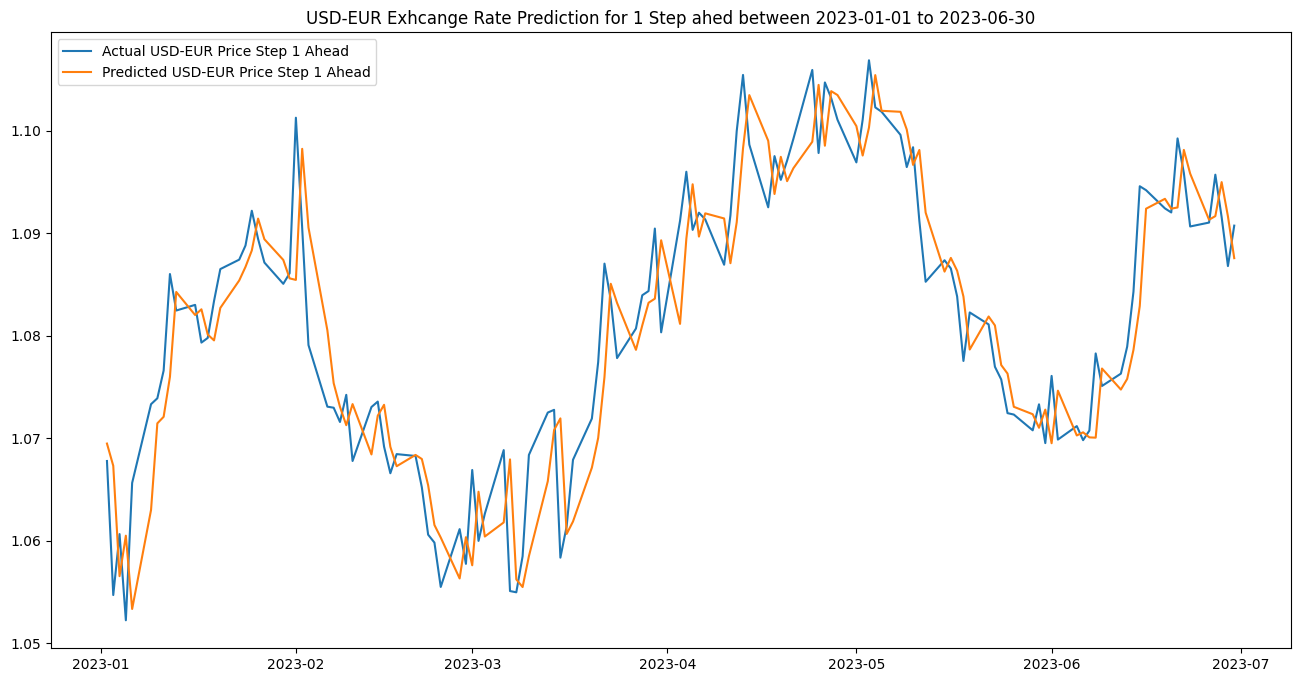

In [ ]:
compare_plots(test_data['Actual_USD_EUR_Price_t+1'],
              test_data['Predicted_USD_EUR_Price_t+1'],
              "Actual USD-EUR Price Step 1 Ahead",
              "Predicted USD-EUR Price Step 1 Ahead",
              "USD-EUR Exhcange Rate Prediction for 1 Step ahed between 2023-01-01 to 2023-06-30")


# 5 Step Ahead Predicction Plot Comparison

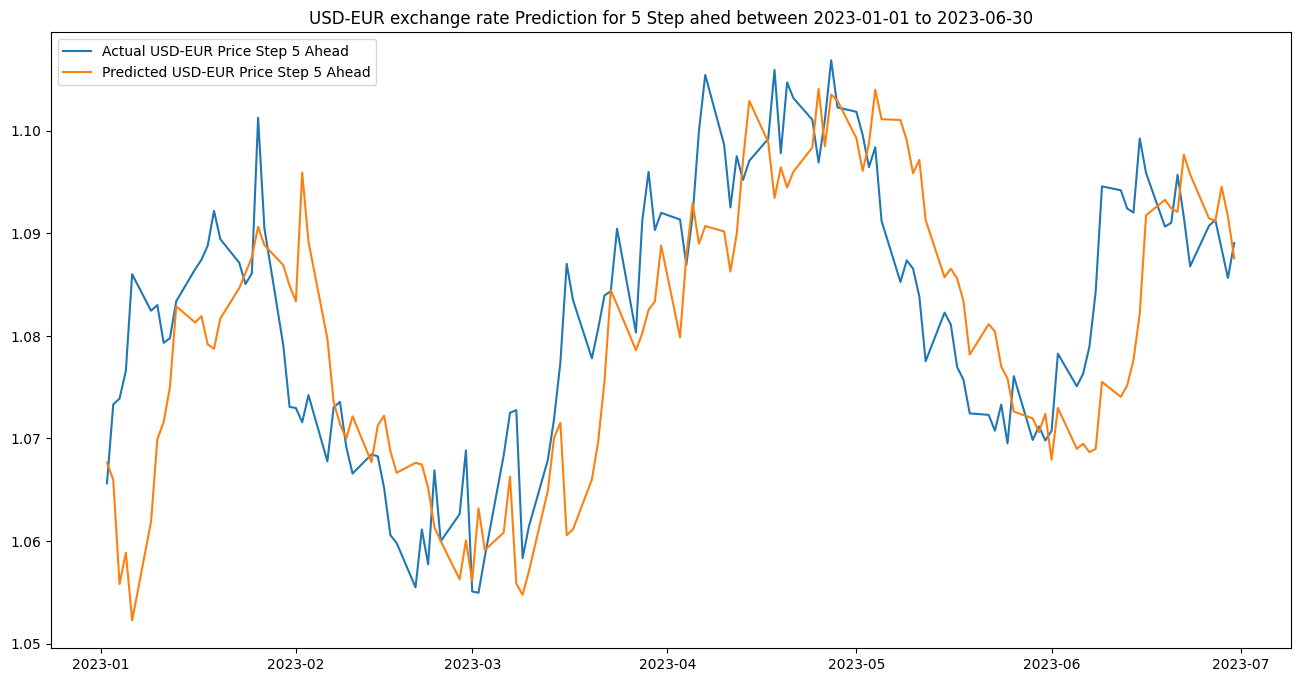

In [ ]:
compare_plots(test_data['Actual_USD_EUR_Price_t+5'],
              test_data['Predicted_USD_EUR_Price_t+5'],
              "Actual USD-EUR Price Step 5 Ahead",
              "Predicted USD-EUR Price Step 5 Ahead",
              "USD-EUR exchange rate Prediction for 5 Step ahed between 2023-01-01 to 2023-06-30")


#Oil

# Selecting the Feature Columns & Prediction Column whcih will be used for Prediction


In [ ]:
DateAttributes=['day','month']


In [ ]:
FeatureColumnsOil = [col for col in df_oil_currency.columns if col.startswith('Actual_Oil_Price_t-') ]
FeatureColumnsOil.insert(0,'Actual_Oil_Price_t')
FeatureColumnsOil.extend(DateAttributes)

PredictedColumnOil='Actual_Oil_Price_t+1'
FeatureColumnsOil

['Actual_Oil_Price_t',
 'Actual_Oil_Price_t-1',
 'Actual_Oil_Price_t-2',
 'Actual_Oil_Price_t-3',
 'Actual_Oil_Price_t-4',
 'day',
 'month']

# Scaling the values to bring them on same Scale


In [ ]:

from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Initialize the scalers
Oilscaler = MinMaxScaler(feature_range=(0,1))
Oilscaler_y = MinMaxScaler(feature_range=(0,1))

# Extract and scale the input features
X_train_oil = train_data[FeatureColumnsOil].values
X_train_oil_scaled = Oilscaler.fit_transform(X_train_oil)

# Extract and scale the target variable, then reshape to 1D array for training
Y_train_oil = train_data[PredictedColumnOil].values
Y_train_oil_scaled = Oilscaler_y.fit_transform(Y_train_oil.reshape(-1,1)).ravel()


#Finding the Best Param


In [ ]:


# Assuming you have X_train and Y_train already defined
best_params_Oil = find_best_mlp_params(X_train_oil_scaled,Y_train_oil_scaled)
selected_columns = best_params_Oil.groupby('param_activation')[['mean_test_score']].idxmax()
best_params_Oil = best_params_Oil.loc[selected_columns['mean_test_score'],
                         ['param_activation', 'param_alpha',
                          'param_hidden_layer_sizes',
                          'param_learning_rate', 'param_solver',
                          'mean_test_score']]
best_params_Oil.sort_values(by='mean_test_score', ascending=False)


,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,mean_test_score
94,relu,0.1,10,adaptive,lbfgs,0.979131
199,identity,0.1,10,constant,lbfgs,0.978853
43,tanh,0.1,10,invscaling,lbfgs,0.971422
127,logistic,0.05,10,constant,lbfgs,0.958962


In [ ]:

for index, params in best_params_Oil.iterrows():
    model = train_mlp(X_train_oil_scaled,Y_train_oil_scaled, params.to_dict())


Score for identity: 0.9939102398442116
Score for logistic: 0.9899013892359402
Score for relu: 0.9941472617699403
Score for tanh: 0.9927504981429904


#Fitting the Model


In [ ]:
relu_Oil_params = best_params_Oil[best_params_Oil['param_activation'] == 'relu']
print(relu_Oil_params.iloc[0].to_dict())
Oilmodel = train_mlp(X_train_oil_scaled,Y_train_oil_scaled, relu_Oil_params.iloc[0].to_dict())

{'param_activation': 'relu', 'param_alpha': 0.1, 'param_hidden_layer_sizes': 10, 'param_learning_rate': 'adaptive', 'param_solver': 'lbfgs', 'mean_test_score': 0.9791307885976659}
Score for relu: 0.9941472617699403


# Recursive multi-step forecasting using 1 Step Ahead model to Predict upto 5 Step Ahead for Oil Price


In [ ]:
StepsAheadPrediction=5
FeatureColumnsOil = [col for col in df_oil_currency.columns if col.startswith('Actual_Oil_Price_t-') and col.endswith('')]
FeatureColumnsOil.insert(0,'Actual_Oil_Price_t')
for i in range(1,StepsAheadPrediction+1):
  print(FeatureColumnsOil)
  X_test = test_data[FeatureColumnsOil+DateAttributes].values
  X_test_scaled = Oilscaler.transform(X_test)
  scaled_predictions = Oilmodel.predict(X_test_scaled)
  scaled_predictions = scaled_predictions.reshape(-1, 1)
  predictions = Oilscaler_y.inverse_transform(scaled_predictions)
  test_data['Predicted_Oil_Price_t+'+str(i)] = predictions
  FeatureColumnsOil.pop(-1)
  FeatureColumnsOil.insert(0,'Predicted_Oil_Price_t+'+str(i))


['Actual_Oil_Price_t', 'Actual_Oil_Price_t-1', 'Actual_Oil_Price_t-2', 'Actual_Oil_Price_t-3', 'Actual_Oil_Price_t-4']
['Predicted_Oil_Price_t+1', 'Actual_Oil_Price_t', 'Actual_Oil_Price_t-1', 'Actual_Oil_Price_t-2', 'Actual_Oil_Price_t-3']
['Predicted_Oil_Price_t+2', 'Predicted_Oil_Price_t+1', 'Actual_Oil_Price_t', 'Actual_Oil_Price_t-1', 'Actual_Oil_Price_t-2']
['Predicted_Oil_Price_t+3', 'Predicted_Oil_Price_t+2', 'Predicted_Oil_Price_t+1', 'Actual_Oil_Price_t', 'Actual_Oil_Price_t-1']
['Predicted_Oil_Price_t+4', 'Predicted_Oil_Price_t+3', 'Predicted_Oil_Price_t+2', 'Predicted_Oil_Price_t+1', 'Actual_Oil_Price_t']


In [ ]:
Oilresults = []

StepsAheadPrediction = 5
for i in range(1, StepsAheadPrediction+1):
    actual_col = f'Actual_Oil_Price_t+{i}'
    predicted_col = f'Predicted_Oil_Price_t+{i}'
    Oilresults.append(calculate_metrics(test_data[actual_col], test_data[predicted_col], actual_col, predicted_col, i))

Oilmetrics = pd.DataFrame(Oilresults)
Oilmetrics


,Original Column,Predicted Column,Steps Ahead,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Mean Absolute Percentage Error
0,Actual_Oil_Price_t+1,Predicted_Oil_Price_t+1,1,1.209208,2.758900,1.660994,1.538682
1,Actual_Oil_Price_t+2,Predicted_Oil_Price_t+2,2,1.846078,5.902174,2.429439,2.354588
2,Actual_Oil_Price_t+3,Predicted_Oil_Price_t+3,3,2.368875,8.702372,2.949978,3.019845
3,Actual_Oil_Price_t+4,Predicted_Oil_Price_t+4,4,2.880087,11.461117,3.385427,3.663735
4,Actual_Oil_Price_t+5,Predicted_Oil_Price_t+5,5,3.261196,15.343356,3.917060,4.139418


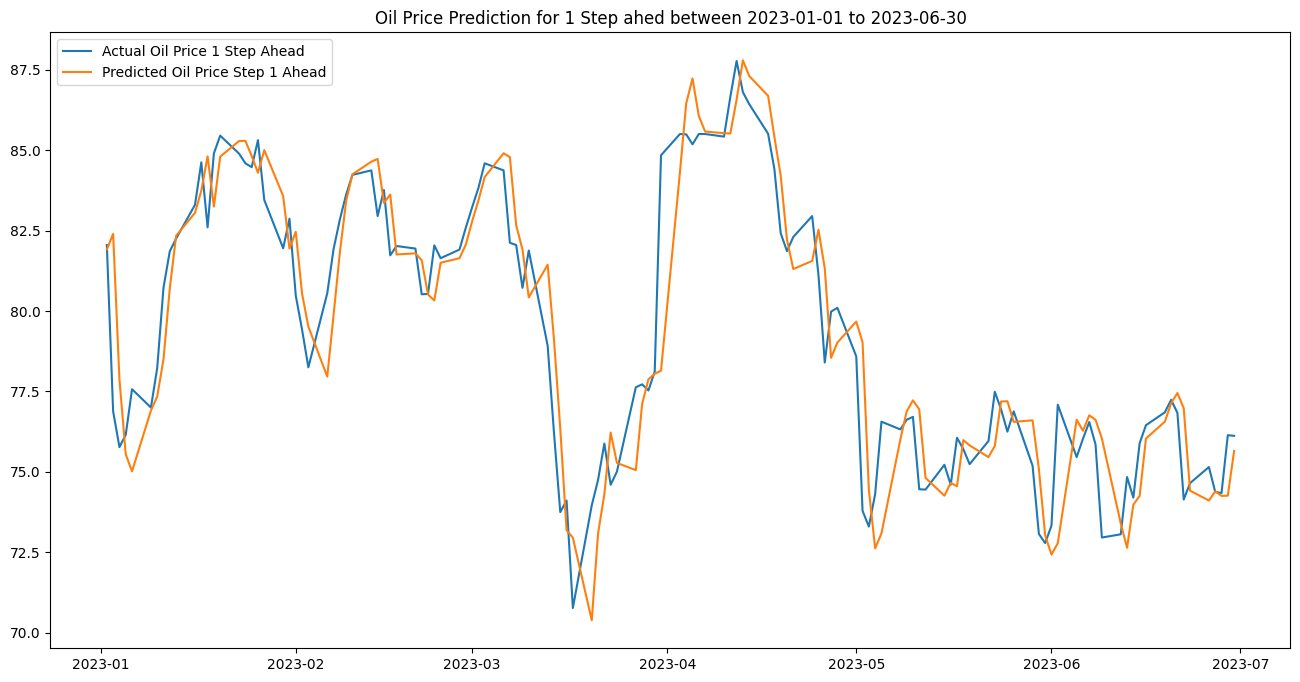

In [ ]:
compare_plots(test_data['Actual_Oil_Price_t+1'],
              test_data['Predicted_Oil_Price_t+1'],
              "Actual Oil Price 1 Step Ahead",
              "Predicted Oil Price Step 1 Ahead",
              "Oil Price Prediction for 1 Step ahed between 2023-01-01 to 2023-06-30")


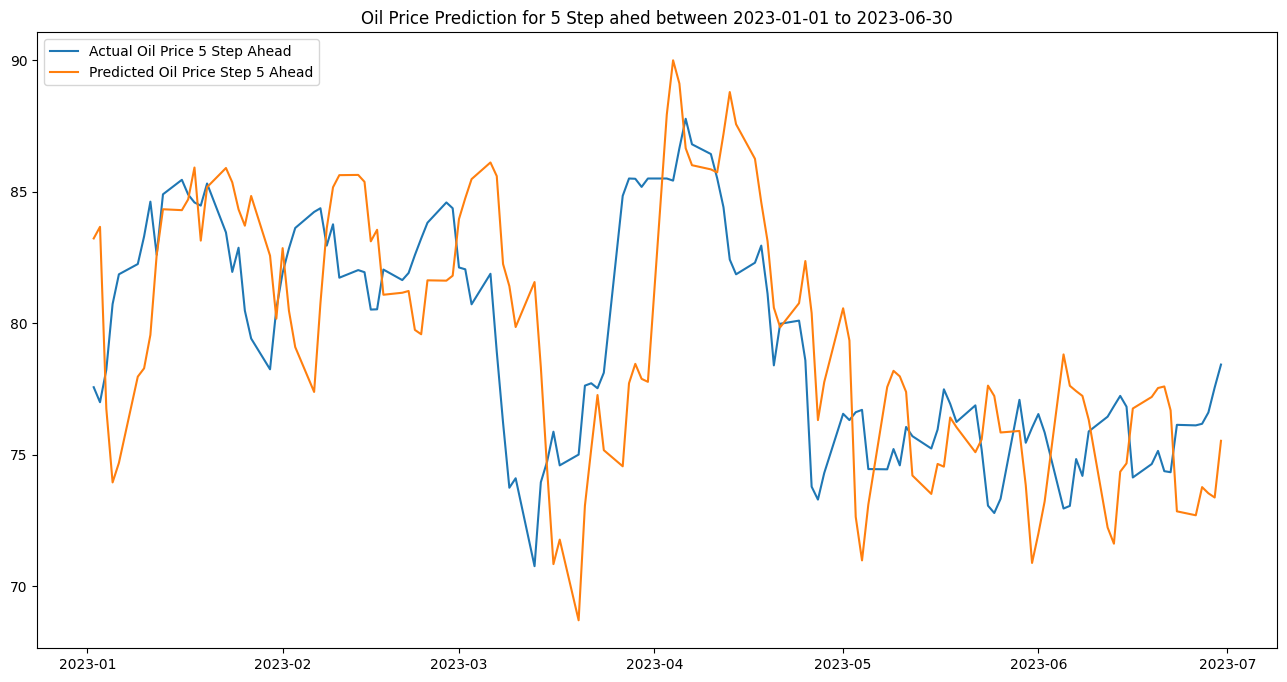

In [ ]:
compare_plots(test_data['Actual_Oil_Price_t+5'],
              test_data['Predicted_Oil_Price_t+5'],
              "Actual Oil Price 5 Step Ahead",
              "Predicted Oil Price Step 5 Ahead",
              "Oil Price Prediction for 5 Step ahed between 2023-01-01 to 2023-06-30")


#Currency + OIL

# Selecting the Feature Columns & Prediction Column which will be used for Prediction


In [ ]:
DateAttributes=['day','month']


In [ ]:
FeatureColumnsOilCurrency = [col for col in train_data.columns if col.startswith('Actual_USD_EUR_Price_t-')]
FeatureColumnsOilCurrency.insert(0,'Actual_USD_EUR_Price_t')

FeatureColumnsOilCurrency.append('Actual_Oil_Price_t+1')
FeatureColumnsOilCurrency.extend(DateAttributes)

PredictedColumnOilCurrency='Actual_USD_EUR_Price_t+1'
FeatureColumnsOilCurrency

['Actual_USD_EUR_Price_t',
 'Actual_USD_EUR_Price_t-1',
 'Actual_USD_EUR_Price_t-2',
 'Actual_USD_EUR_Price_t-3',
 'Actual_USD_EUR_Price_t-4',
 'Actual_Oil_Price_t+1',
 'day',
 'month']

# Scaling the values to bring them on same Scale


In [ ]:

from sklearn.preprocessing import StandardScaler,MinMaxScaler
CurOilscaler = MinMaxScaler(feature_range=(0,1))

X_train = train_data[FeatureColumnsOilCurrency].values
X_train_scaled = CurOilscaler.fit_transform(X_train)

CurOilscaler_y = MinMaxScaler(feature_range=(0,1))

Y_train = train_data[PredictedColumnOilCurrency].values
Y_train_scaled = CurOilscaler_y.fit_transform(Y_train.reshape(-1,1))



#Finding the Best Param


In [ ]:

best_params_CurOil = find_best_mlp_params(X_train_scaled, Y_train_scaled.ravel())

selected_columns = best_params_CurOil.groupby('param_activation')[['mean_test_score']].idxmax()
best_params_CurOil = best_params_CurOil.loc[selected_columns['mean_test_score'],
                         ['param_activation', 'param_alpha',
                          'param_hidden_layer_sizes',
                          'param_learning_rate', 'param_solver',
                          'mean_test_score']]
best_params_CurOil.sort_values(by='mean_test_score', ascending=False)


,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,mean_test_score
163,identity,0.0001,10,constant,lbfgs,0.954650
73,relu,0.05,10,constant,lbfgs,0.949498
25,tanh,0.05,10,invscaling,lbfgs,0.939465
109,logistic,0.0001,10,constant,lbfgs,0.895387


In [ ]:
for index, params in best_params_CurOil.iterrows():
    model = train_mlp(X_train_scaled, Y_train_scaled.ravel(), params.to_dict())


Score for identity: 0.9926553421822718
Score for logistic: 0.9917370611743608
Score for relu: 0.9918837791779258
Score for tanh: 0.9927608786727616


#Fitting the Model

In [ ]:
relu_CurOil_params = best_params_CurOil[best_params_CurOil['param_activation'] == 'relu']
print(relu_CurOil_params.iloc[0].to_dict())
CurOilmodel = train_mlp(X_train_scaled, Y_train_scaled.ravel(), relu_CurOil_params.iloc[0].to_dict())

{'param_activation': 'relu', 'param_alpha': 0.05, 'param_hidden_layer_sizes': 10, 'param_learning_rate': 'constant', 'param_solver': 'lbfgs', 'mean_test_score': 0.9494979022186216}
Score for relu: 0.9918837791779258


#Recursive multi-step forecasting using 1 Step Ahead model to Preict upto 5 Step Ahead for USD-EUR Exchange rate by using Oil Prices to validate its impact


In [ ]:
FeatureColumnsOilCurrency=['Actual_USD_EUR_Price_t','Actual_USD_EUR_Price_t-1','Actual_USD_EUR_Price_t-2','Actual_USD_EUR_Price_t-3','Actual_USD_EUR_Price_t-4']
StepsAheadPrediction=5
for i in range(1,StepsAheadPrediction+1):
  FeatureColumnsOilCurrency.append('Predicted_Oil_Price_t+'+ str(i))
  print(FeatureColumnsOilCurrency+DateAttributes)
  X_test = test_data[FeatureColumnsOilCurrency+DateAttributes].values
  X_test_scaled = CurOilscaler.transform(X_test)
  scaled_predictions = CurOilmodel.predict(X_test_scaled).reshape(-1, 1)
  # inverse transform the scaled predictions
  predictions = CurOilscaler_y.inverse_transform(scaled_predictions)
  test_data['Predicted_USD_EUR_Price_WithOil_t+'+str(i)] = predictions
  FeatureColumnsOilCurrency.remove('Predicted_Oil_Price_t+'+ str(i))
  FeatureColumnsOilCurrency.pop(-1)
  FeatureColumnsOilCurrency.insert(0,'Predicted_USD_EUR_Price_WithOil_t+'+str(i))


['Actual_USD_EUR_Price_t', 'Actual_USD_EUR_Price_t-1', 'Actual_USD_EUR_Price_t-2', 'Actual_USD_EUR_Price_t-3', 'Actual_USD_EUR_Price_t-4', 'Predicted_Oil_Price_t+1', 'day', 'month']
['Predicted_USD_EUR_Price_WithOil_t+1', 'Actual_USD_EUR_Price_t', 'Actual_USD_EUR_Price_t-1', 'Actual_USD_EUR_Price_t-2', 'Actual_USD_EUR_Price_t-3', 'Predicted_Oil_Price_t+2', 'day', 'month']
['Predicted_USD_EUR_Price_WithOil_t+2', 'Predicted_USD_EUR_Price_WithOil_t+1', 'Actual_USD_EUR_Price_t', 'Actual_USD_EUR_Price_t-1', 'Actual_USD_EUR_Price_t-2', 'Predicted_Oil_Price_t+3', 'day', 'month']
['Predicted_USD_EUR_Price_WithOil_t+3', 'Predicted_USD_EUR_Price_WithOil_t+2', 'Predicted_USD_EUR_Price_WithOil_t+1', 'Actual_USD_EUR_Price_t', 'Actual_USD_EUR_Price_t-1', 'Predicted_Oil_Price_t+4', 'day', 'month']
['Predicted_USD_EUR_Price_WithOil_t+4', 'Predicted_USD_EUR_Price_WithOil_t+3', 'Predicted_USD_EUR_Price_WithOil_t+2', 'Predicted_USD_EUR_Price_WithOil_t+1', 'Actual_USD_EUR_Price_t', 'Predicted_Oil_Price_t+

In [ ]:
Exchangeresults = []
StepsAheadPrediction = 5

for i in range(1, StepsAheadPrediction+1):
    actual_col = f'Actual_USD_EUR_Price_t+{i}'
    predicted_col = f'Predicted_USD_EUR_Price_WithOil_t+{i}'
    Exchangeresults.append(calculate_metrics(test_data[actual_col], test_data[predicted_col], actual_col, predicted_col, i))

Exchangemetrics = pd.DataFrame(Exchangeresults)
Exchangemetrics

,Original Column,Predicted Column,Steps Ahead,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Mean Absolute Percentage Error
0,Actual_USD_EUR_Price_t+1,Predicted_USD_EUR_Price_WithOil_t+1,1,0.004547,0.000034,0.005800,0.420509
1,Actual_USD_EUR_Price_t+2,Predicted_USD_EUR_Price_WithOil_t+2,2,0.005488,0.000051,0.007148,0.507663
2,Actual_USD_EUR_Price_t+3,Predicted_USD_EUR_Price_WithOil_t+3,3,0.006319,0.000062,0.007860,0.584685
3,Actual_USD_EUR_Price_t+4,Predicted_USD_EUR_Price_WithOil_t+4,4,0.006924,0.000078,0.008811,0.640150
4,Actual_USD_EUR_Price_t+5,Predicted_USD_EUR_Price_WithOil_t+5,5,0.007616,0.000095,0.009729,0.703455


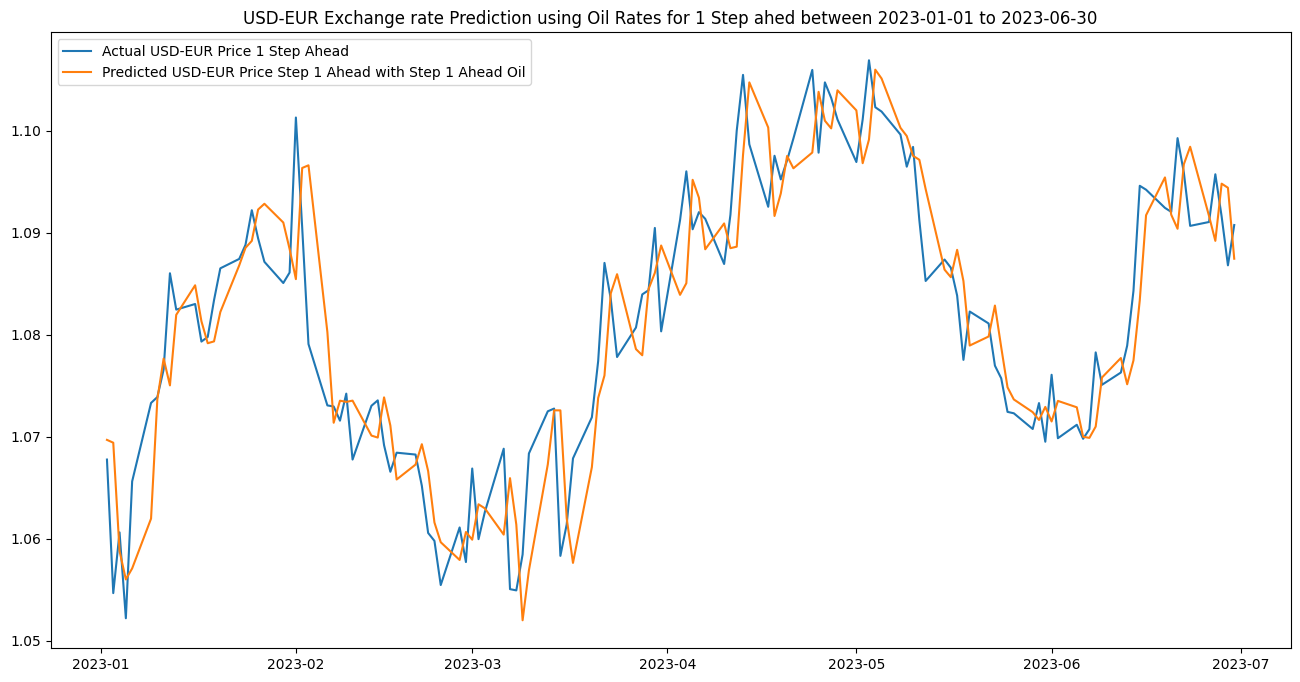

In [ ]:
compare_plots(test_data['Actual_USD_EUR_Price_t+1'],
              test_data['Predicted_USD_EUR_Price_WithOil_t+1'],
              "Actual USD-EUR Price 1 Step Ahead",
              "Predicted USD-EUR Price Step 1 Ahead with Step 1 Ahead Oil",
              "USD-EUR Exchange rate Prediction using Oil Rates for 1 Step ahed between 2023-01-01 to 2023-06-30")


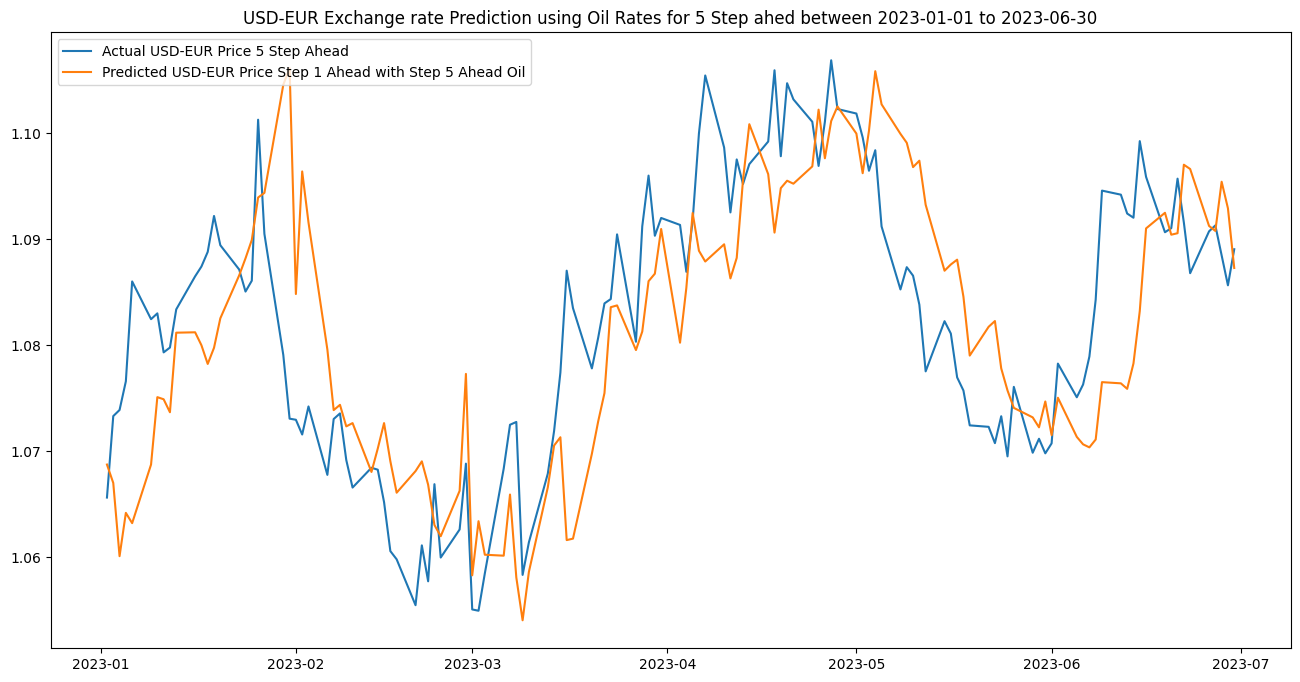

In [ ]:
compare_plots(test_data['Actual_USD_EUR_Price_t+5'],
              test_data['Predicted_USD_EUR_Price_WithOil_t+5'],
              "Actual USD-EUR Price 5 Step Ahead",
              "Predicted USD-EUR Price Step 1 Ahead with Step 5 Ahead Oil",
              "USD-EUR Exchange rate Prediction using Oil Rates for 5 Step ahed between 2023-01-01 to 2023-06-30")
